# Basic Regression: Predict Fule Efficiency

This project aims to predict the output of a continuous value, like a price or probablity.

The tutorial will use the classic auto mpg dataset and demonstrates how to build models to predict the fuel efficiency of the late 1970 and early 1980 automobiles.

We will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders and displacement, horsepower and weight

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# make numpy printout easier to read
np.set_printoptions(precision=3, suppress=True)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Get the data

Download the and import the dataset using pandas

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                            na_values='?', comment='\t',
                            sep=' ', skipinitialspace=True)

In [4]:
datatset = raw_dataset.copy()
datatset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

dataset contain a few unkown values

In [6]:
datatset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

We will be dropping the rows

In [7]:
datatset = datatset.dropna()

The orgin column is categorical, not numeric. Next step is to onehot enocde the values in the column

In [8]:
datatset['Origin'] = datatset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
datatset = pd.get_dummies(datatset, columns=['Origin'], prefix='', prefix_sep='')
datatset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## split the data into training and test sets

split the dataset into a training set and test set.

We will use the test set for the final evaluation of the model.

In [10]:
train_dataset = datatset.sample(frac=0.8, random_state=0)
test_dataset = datatset.drop(train_dataset.index)

## Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

Top row suggests that the fuel efficiency is a function of all the other paramerters.

The other rows indicate they are functions of each other

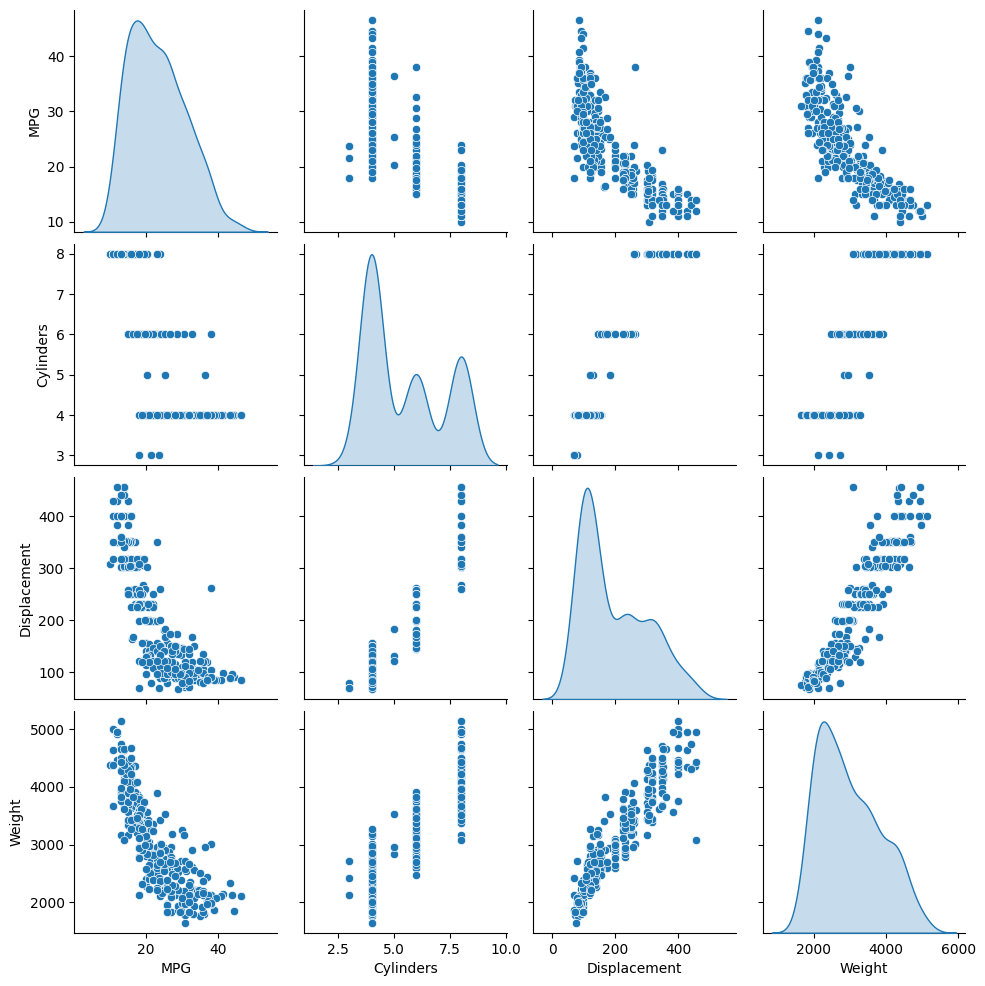

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Check the overal statistics 

Note how each feature covers a very different range

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split the features from the labels

We will need to separate the target values - the "label" - from the featues.

This label is the value that you will train the model to predict. 

In [13]:
train_feature = train_dataset.copy()
test_feature = test_dataset.copy()

train_labels = train_feature.pop('MPG')
test_labels = test_feature.pop('MPG')

## Normalization

In the table statistics its easy to see how different the ranges of each feature are

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason is because the features are multipled by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

Note: there is no advantage to normalizing the one-hot features - its done here for simiplicity

## The normalization layer

the keras.layers.normalization is a clean and simple way to add features normalization into your model

the first step is to create the layer

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then we will need to fit the state of the preprocessing layer to the data by calling normalization.adapt

In [16]:
normalizer.adapt(np.array(train_feature))

2023-02-11 15:16:08.797196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-11 15:16:08.798992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-11 15:16:08.945497: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-11 15:16:09.085419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 15:16:09.109539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Calculate the mean and variance, and store them in the layer

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called it returens the input data with each feature independently normalized

In [18]:
first = np.array(train_feature[:1])

with np.printoptions(precision=2, suppress=True):
    print('first example:', first)
    print()
    print('normalized:', normalizer(first).numpy())

first example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear Regression

Before building a deep neural network model, start with linear regression using one and several variables

### Linear regression with single variable

Begin with a single-variable linear regression to predict mpg from horsepower

Training a model with tf.keras typically starts wby defining the model architecture. Use a a tf.keras.sequential model with represents a sequence of steps.

There are two steps in your single variable linear regression model:
- Normalize the horsepower input features using the tf.keras.layers.normalization preprocessing layer
- apply a liner transflowrmation (y = mx + b) to preduce 1 output using a linear layer (tf.keras.layers.dense)

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First create a numpy array mode of the 'horsepower' features. Then instantiate the tf.keras.layers.normalization and fit its state to the horsepower data

In [19]:
horsepower = np.array(train_feature['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

2023-02-11 15:46:47.395960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 15:46:47.418019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Build the keras sequential model

In [20]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict the mpg from horsepower

Run the untrained model on the first 10 horsepower values. The output wont be good, but notice that it has the unexpected shape of (10, 1)

In [21]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 238ms/step


2023-02-11 15:51:43.500391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[ 1.144],
       [ 0.646],
       [-2.112],
       [ 1.604],
       [ 1.45 ],
       [ 0.57 ],
       [ 1.719],
       [ 1.45 ],
       [ 0.378],
       [ 0.646]], dtype=float32)

Once the model is built, configure the training procedure using keras model.compile method.

The most important argument to compile are the loss and optimizer, since thse define what will be optimized and how

In [23]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

Use the keras model.fit to execute the training for 100 epochs

In [24]:
%%time
history = horsepower_model.fit(
    train_feature['Horsepower'],
    train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # calculate validation results on 20% of the training data
    validation_split = 0.2
)

/Users/eric/keras-env/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-02-11 16:37:15.511974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 16:37:15.982821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.71 s, sys: 1.68 s, total: 5.39 s
Wall time: 5.14 s


visualize the model training progress using the stats stored in the history object

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806799,4.169278,95
96,3.805591,4.168586,96
97,3.803064,4.189093,97
98,3.803648,4.193965,98
99,3.802614,4.194021,99


In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [mpg]')
    plt.legend()
    plt.grid(True)

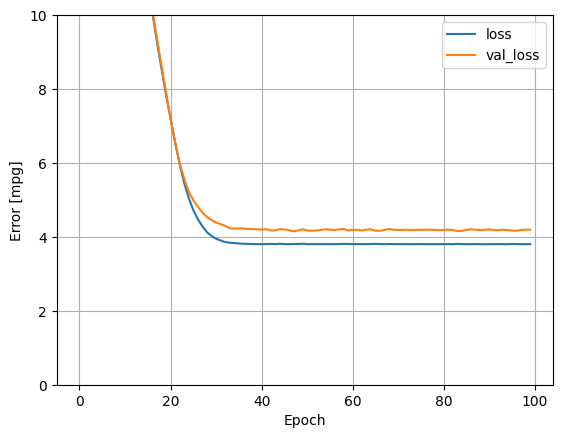

In [27]:
plot_loss(history)

Collect the results on the test set for later

In [28]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_feature['Horsepower'],
    test_labels, verbose=0
)

Because this is a single variable regression

its easy to view the model prediction as a functions as a function of the inputs

In [29]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


2023-02-11 16:43:45.747358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [30]:
def plot_hoursepower(x, y):
    plt.scatter(train_feature['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

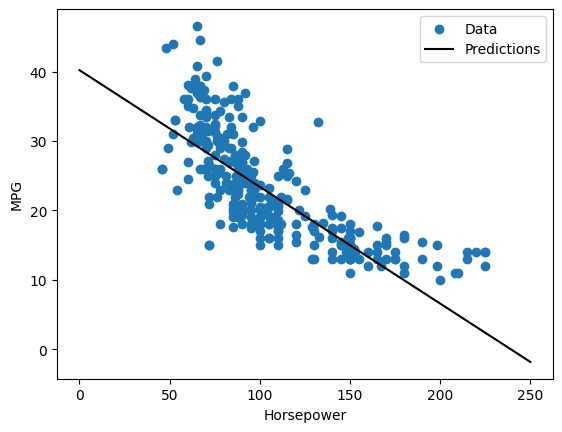

In [31]:
plot_hoursepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. 

This model still does the same y=mx+b expect that m is a matrix and b is vector.



Create a two-step keras sequential model again with the first layer being normalizer you defined earlier and adapted to the whole dataset

In [32]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call model.predict on a batch of inputs, it produces unit=1 outputs for each example

In [33]:
linear_model.predict(train_feature[:10])

1/1 [==============================] - 0s 149ms/step


2023-02-11 16:50:24.618402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[-0.435],
       [-0.707],
       [-1.508],
       [-0.543],
       [ 1.553],
       [-1.337],
       [ 1.409],
       [ 2.349],
       [-1.226],
       [ 1.426]], dtype=float32)

When you call the model, its weight matrices will be built - check the kernel weights (the m in y = mx+ b) have a shape of (9, 1)

In [35]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.654],
       [-0.076],
       [-0.414],
       [ 0.5  ],
       [-0.422],
       [-0.091],
       [ 0.754],
       [ 0.485],
       [-0.655]], dtype=float32)>

Configure the model with keras model.compile and train with model.fit for 100 epochs

In [36]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [37]:
%%time
history = linear_model.fit(
    train_feature,
    train_labels,
    epochs=100,
    # supress logging
    verbose = 0,
    # calculate validation results on 20% of the training data
    validation_split = 0.2
)

/Users/eric/keras-env/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-02-11 16:54:51.992703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 16:54:52.189002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.7 s, sys: 1.66 s, total: 5.36 s
Wall time: 4.67 s


Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model, which as one input

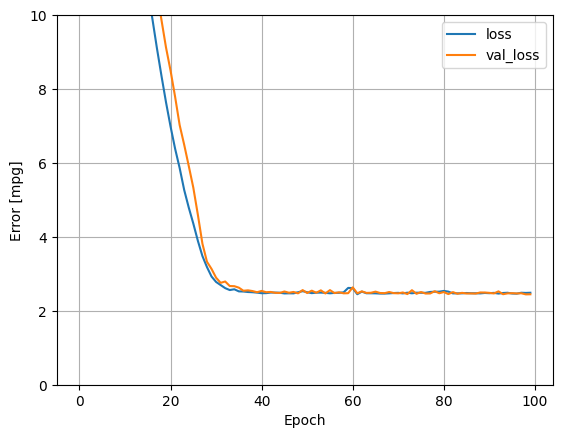

In [39]:
plot_loss(history)

Collect the results on the test set for later

In [40]:
test_results['linear_model'] = linear_model.evaluate(
    test_feature, test_labels, verbose=0
)

## Regression with deep neural network (dnn)

In previous section, we implemented two linear models for single and multiple inputs.

Here we will implement single-input and multiple-input dnn models

The code is basically the same expect the model is expanded to include some "hidden" non_linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These model will contain a few more layers than a linear model:
- The normalization layer, as before (with horsepower_normalizer) for a single-input model and normalizer for a multiple-input model
- two hidden, non-linear dense layers with the relu activation function nonlinearity.
- A linear dense single output layer

Both models will use the same trainng procedure, so the compile method is included in the built and compile model function below

In [41]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

### Regression using a DNN and a single input

Create a dnn model with only horsepower as input and horsepower_normalizer as the normalization layer

In [42]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models

In [43]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with keras model.fit

In [44]:
%%time
history = dnn_horsepower_model.fit(
    train_feature['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

/Users/eric/keras-env/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-02-11 17:08:21.441134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 17:08:22.108314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 4.41 s, sys: 1.75 s, total: 6.16 s
Wall time: 5.92 s


This model does slightly better than the linear single-input horsepower_model

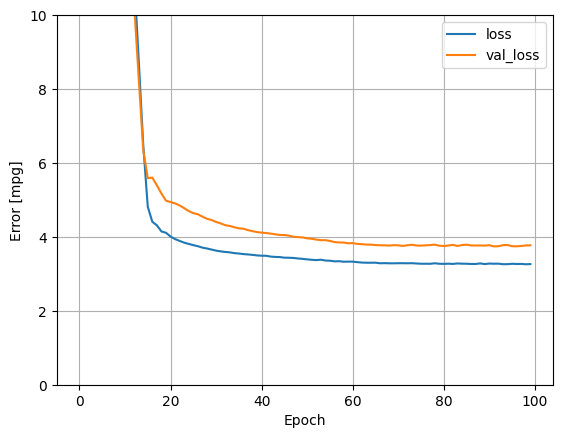

In [45]:
plot_loss(history)

if you plot the predictions as a function of horsepower you should notice how this model takes advantage of the nonlinearity provide by the hidden layers

In [46]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 4ms/step


2023-02-11 17:11:22.497529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


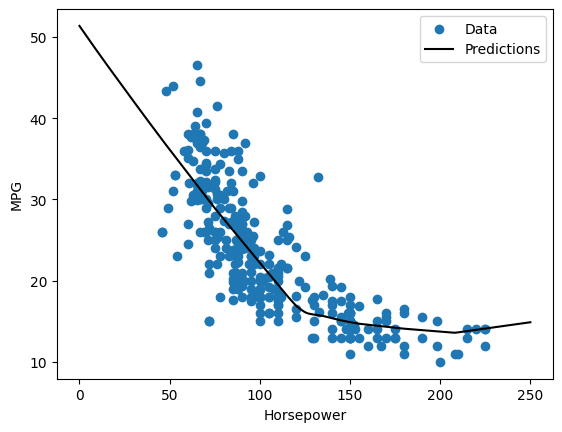

In [47]:
plot_hoursepower(x, y)

Collect the result on the test set for later

In [48]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_feature['Horsepower'], test_labels,
    verbose=0
)

### Regression using dnn and multiple inputs

Repeat the previous using all the inputs. 

The models preformance slightly improves on the validation dataset

In [49]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [50]:
%%time
history = dnn_model.fit(
    train_feature,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

/Users/eric/keras-env/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2023-02-11 17:15:19.935704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-11 17:15:20.387375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 4.51 s, sys: 1.87 s, total: 6.38 s
Wall time: 5.8 s


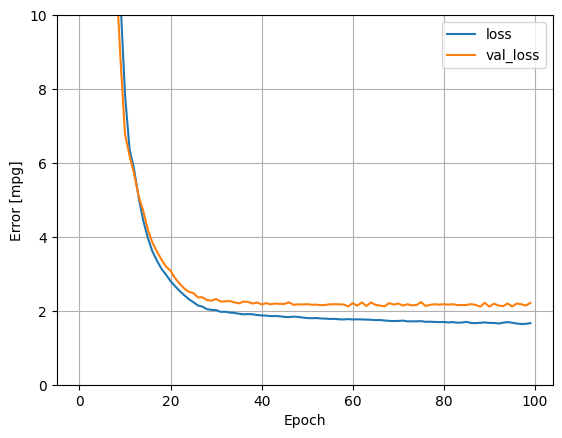

In [51]:
plot_loss(history)

Collect the results on the test set

In [52]:
test_results['dnn_model'] = dnn_model.evaluate(test_feature, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance

In [53]:
pd.DataFrame(test_results, index=['Mean absolute error [mpg]']).T

,Mean absolute error [mpg]
horsepower_model,3.643980
linear_model,2.500153
dnn_horsepower_model,2.920608
dnn_model,1.641875


These results match the validation error observed during training

## Make predictions

You can now make predictions with the dnn_model on the test set using keras model.predict and reivew the loss

3/3 [==============================] - 0s 11ms/step


2023-02-11 17:21:15.220566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


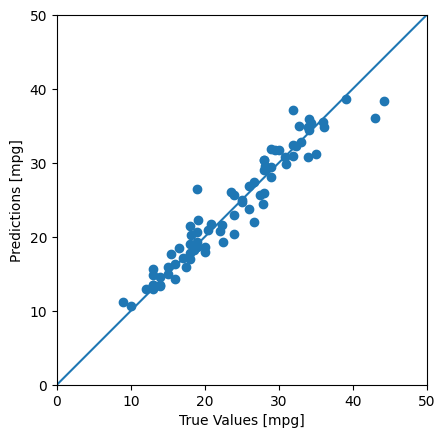

In [54]:
test_predictions = dnn_model.predict(test_feature).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [mpg]')
plt.ylabel('Predictions [mpg]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It appears that the mondel predicts reasonably well

Now, check the error distribution

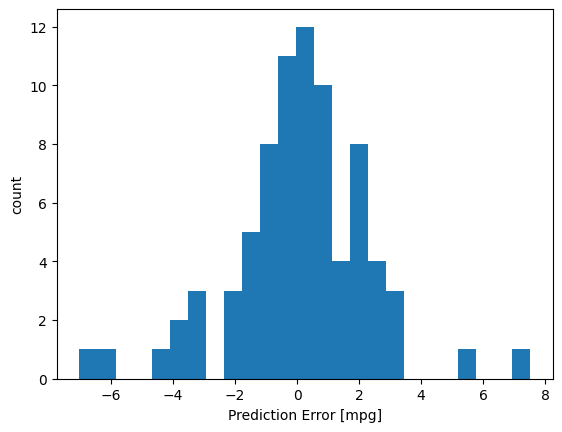

In [55]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [mpg]')
_ = plt.ylabel('count')

If you are happy with the results. The model can be saved for later use

In [56]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


## Conclusion

This notebook introuced a few techniques to handle a regression problem.

Here are a few more tips that mapy help:
- Mean squared error (mse) and mean absolute error (mae) are common loss functions used for regression problems mae is less sensitive to outliers. Different loss functions are used for classification problems
- similary, evaluation metrics used for regression differ from classification
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range
- overfitting is a common problem for dnn models. 